# 팀 프로젝트 업그레이드
# 팀 6 / 주제: 데이터로 알아보는 영화의 흥행공식
### 팀원: 심우석 이도원 우윤형 정유경 정의진

***

# 주요 이슈 및 개선방향
## 1) 제작사 입장에선 수익률 이외의 데이터인 평균평점이나 영화 수를 보는 건 큰 의미가 없다.

이를 위해 영화 제작 전 평균 평점이나 영화 수를 고려한 사례를 조사하고, 해당 지표들이 제작자에게 어떤 의미를 가지는지 조사함. 이후 ROI와의 상관관계를 분석한 결과, 뚜렷한 상관관계는 나타나지 않음. 또한영화사의 입장에서 ROI, 평균 평점, 영화수의 타협점을 나름대로 선정해봄.

## 2) 장르별 평균 ROI 데이터가 지나치게 높다.

장르별 평균 ROI 분석 시, DRAMA 장르는 다른 장르에 비해 ROI 값이 극단적으로 높아 이상치로 판단됨. 전체 데이터의 왜곡을 방지하고 보다 정확한 비교를 위해 DRAMA 장르 데이터를 다시 검토하였고 지나치게 높은 이상치를 제거하여 재시각화함.

## 3) 평점 수와 평점간의 관계 측면을 고려하지 않음. 평점을 비교할 때는 영화별 평가자 수 분포와 분석에 사용된 연도 기준이 중요하며, 평가자 수가 적으면 평점 신뢰도가 낮아질 수 있고, 장르별 등장 시기의 차이는 평균 평점에 영향을 줄 수 있으므로, 두 요소 모두 통제하거나 명시해야한다.

평점 수에 따라 [20개 미만 → 매우 낮음, 100개 미만 → 낮음, 1000개 미만 → 보통, 1000개 이상 → 높음]으로 신뢰도 구간을 나눈 뒤, 각 구간별 평점 분포를 분석한 결과, 신뢰도가 높을수록 평균 평점은 높고 분산은 작으며, 신뢰도가 낮을수록 평균은 낮고 분산은 큼을 확인함. 이에 따라 신뢰도 확보를 위해 평점 수 100개 이상 영화만을 추출해 분석을 재진행함.


## 4) 상위 25% 평점 영화만 비교하면 드라마처럼 영화 수 자체가 많은 장르가 유리하니, 장르별 전체 수 대비 상위 25% 포함 비율로 비교하는 게 더 적절하다.
상위 25% 영화 수만 비교하면 드라마처럼 수 많은 장르가 유리함. 그래서 전체 대비 상위 25% 비율로 계산해 barplot 그림.


## 5) 수익률 상위 25% 장르별 "작품 수"를 히트맵으로 시각화할 경우, 장르별로 표본 수에 차이가 존재할 수 있어 올바른 데이터 분석이 아닐 수 있다는 피드백과 각 장르별로 몇월에 흥행이 많이되는지 분석하는 것도 좋을 것 같다.
이러한 피드백을 반영하여 장르별 작품 수, 영화시장의 규모(예산) 분석을 통해 표본 수를 다시 구하고 재시각화 함. 


***

## 1) 첫번째 이슈 및 개선 내역


In [6]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rc('font',family='Malgun Gothic') 
mpl.rcParams['axes.unicode_minus'] = False

In [7]:
%precision 3
data = pd.read_csv("tmdb_5000_movies.csv", low_memory=False)
def parse_genres(genre_str): #문자열을 입력
    try:
        genres = ast.literal_eval(genre_str) #파이썬의 리스트 + 딕셔너리로 바꿈
        return [g['name'] for g in genres] # genres는 리스트니까 각 아이템의 name만 추출
    except:
        return [] #비어있거나 한 나머지것들 빈 리스트로
        
data = data.dropna(subset=["budget", "revenue", "vote_average", "genres"])
data["genre_list"] = data["genres"].apply(parse_genres)
data["budget"] = pd.to_numeric(data["budget"], errors="coerce")
data["revenue"] = pd.to_numeric(data["revenue"], errors="coerce")
data = data[(data["budget"] > 0) & (data["revenue"] > 0)]
data["roi"] = data["revenue"] / data["budget"]
data_exploded = data.explode("genre_list")

In [8]:
data_exploded = data_exploded.sort_values(by='roi',ascending=False)
data_exploded[(data_exploded['roi']>=0.1)&(data_exploded['roi']<=20000)]
genre_roi = data_exploded.groupby("genre_list")["roi"].mean().sort_values(ascending=False) 

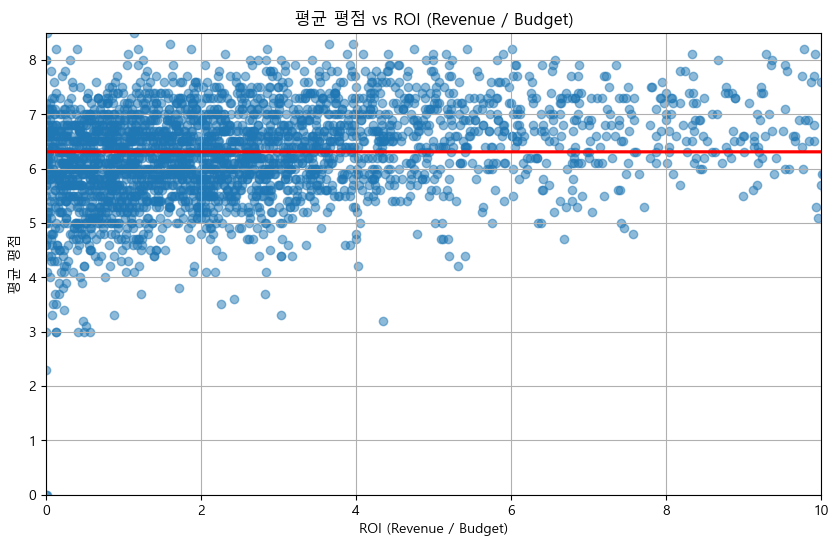

In [9]:
plt.figure(figsize=(10, 6))
sns.regplot(x='roi', y='vote_average', data=data, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('평균 평점 vs ROI (Revenue / Budget)')
plt.xlabel('ROI (Revenue / Budget)')
plt.ylabel('평균 평점')

plt.xlim(0, 10) #데이터가 밀집되어있는 부분을 보여주기 위하여 범위 설정
plt.ylim(data['vote_average'].min(), data['vote_average'].max())

plt.grid(True)
plt.show()

In [10]:
# ROI와 vote_average의 상관계수 계산
correlation = data["roi"].corr(data["vote_average"])
print(f"ROI와 평균 평점 사이의 상관계수: {correlation:.4f}")

ROI와 평균 평점 사이의 상관계수: 0.0325


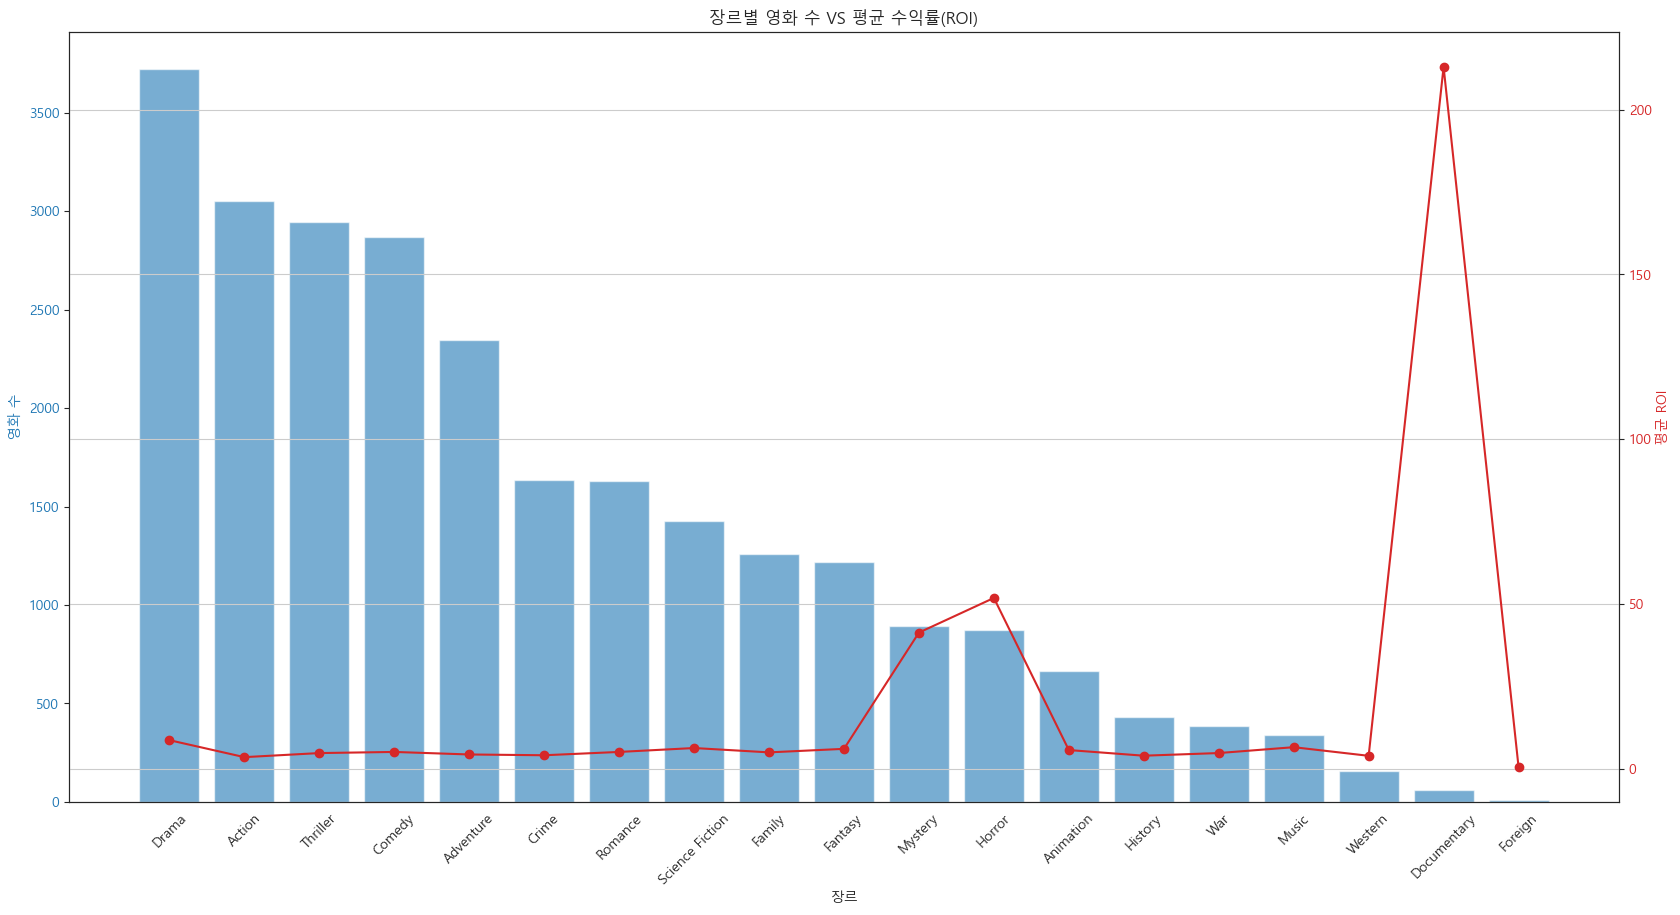

In [269]:
# 장르 리스트 변환
def parse_genres(genre_str): 
    try:
        genres = ast.literal_eval(genre_str) 
        return [g['name'] for g in genres] 
    except:
        return [] 
    
data["genres_list"] = data["genres"].apply(parse_genres)

# 장르별로 분리
data_exploded = data.explode('genres_list')
data = data_exploded.reset_index(drop=True)

data_filtered = data[(data['roi'] >= 0.1) & (data['roi'] <= 20000)]
genre_stats = data_filtered.groupby('genres_list').agg(movie_count=('genres_list', 'count'), avg_roi=('roi', 'mean')).sort_values('movie_count', ascending=False)

fig, ax1 = plt.subplots(figsize=(20, 10))

#영화 수 (bar)
color = 'tab:blue'
ax1.set_xlabel('장르')
ax1.set_ylabel('영화 수', color=color)
ax1.bar(genre_stats.index, genre_stats['movie_count'], color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45)

#평균 ROI (line)
ax2 = ax1.twinx()  # 두 번째 y축 생성
color = 'tab:red'
ax2.set_ylabel('평균 ROI', color=color)
ax2.plot(genre_stats.index, genre_stats['avg_roi'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('장르별 영화 수 VS 평균 수익률(ROI)')

plt.grid(True)
plt.show()

In [267]:
correlation = genre_stats['movie_count'].corr(genre_stats['avg_roi'])
print(f"영화 수와 평균 ROI의 상관계수: {correlation:.4f}")

영화 수와 평균 ROI의 상관계수: -0.2748


ROI, 평균평점, 영화수 간의 타협점

1. ROI는 영화의 수익성을 나타내는 지표로, 투자 대비 얼마나 많은 수익을 올렸는지를 보여준다. ROI가 높은 장르는 재무적으로 수익성이 기대되는 장르를 의미한다. 분석 결과, ROI 상위 장르는 코미디, 드라마, 호러, 스릴러, 다큐멘터리였다.

2. 평점은 관객과 비평가의 작품에 대한 만족도를 나타내며, 장기적으로 프랜차이즈화, 시리즈 제작, 브랜드 가치 형성 등 확장 가능성에 영향을 준다. 본 분석에서는 전체 작품 수 대비 상위 평점을 받은 영화의 비율을 기준으로 각 장르의 평점 수준을 평가하였다. 분석 결과, 평점 상위 장르는 다큐멘터리, 전쟁영화, 서부영화, 역사, 드라마였다.

3. 시장 규모는 해당 장르의 영화 수로 판단하였으며, 이는 제작 기회, 수요, 경쟁 강도 등과 직결된다. 시장 규모가 너무 작으면 불확실성이 높고, 너무 크면 경쟁이 치열할 수 있다. 따라서 적당한 시장 규모를 갖는 장르가 투자와 배급 측면에서 안정적이다. 시장 규모 상위 장르는 드라마, 코미디, 스릴러, 액션, 로맨스였다.

이 세 가지 지표를 종합적으로 만족시키는 장르는 드라마였다. 드라마 장르는 ROI가 높고, 평점도 우수하며, 시장 규모도 과도하지 않으면서 충분한 제작 기회를 제공한다. 또한 다양한 서브장르와의 결합이 가능하고, 국제적인 수요도 고르게 분포되어 있어 확장 가능성도 높다.


***

## 2) 두번째 이슈 및 개선 내역


In [18]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl 
mpl.rc('font',family='Malgun Gothic') 

장르별 평균 ROI 수정본 - 이상치 제거

In [20]:
md = pd.read_csv('tmdb_5000_movies.csv')

In [21]:
md

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
4799,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
4800,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""

In [22]:
%precision 3
data = pd.read_csv("tmdb_5000_movies.csv", low_memory=False)
def parse_genres(genre_str): #문자열을 입력
    try:
        genres = ast.literal_eval(genre_str) #파이썬의 리스트 + 딕셔너리로 바꿈
        return [g['name'] for g in genres] # genres는 리스트니까 각 아이템의 name만 추출
    except:
        return [] #비어있거나 한 나머지것들 빈 리스트로

data["genre_list"] = data["genres"].apply(parse_genres)
data["budget"] = pd.to_numeric(data["budget"], errors="coerce")
data["revenue"] = pd.to_numeric(data["revenue"], errors="coerce")
data = data[(data["budget"] > 0) & (data["revenue"] > 0)]
data["roi"] = data["revenue"] / data["budget"]
data_exploded = data.explode("genre_list")

In [23]:
data_exploded=data_exploded.sort_values(by='roi',ascending=False)
data_exploded[(data_exploded['roi']>=0.1)&(data_exploded['roi']<=20000)]
genre_roi = data_exploded.groupby("genre_list")["roi"].mean().sort_values(ascending=False) 

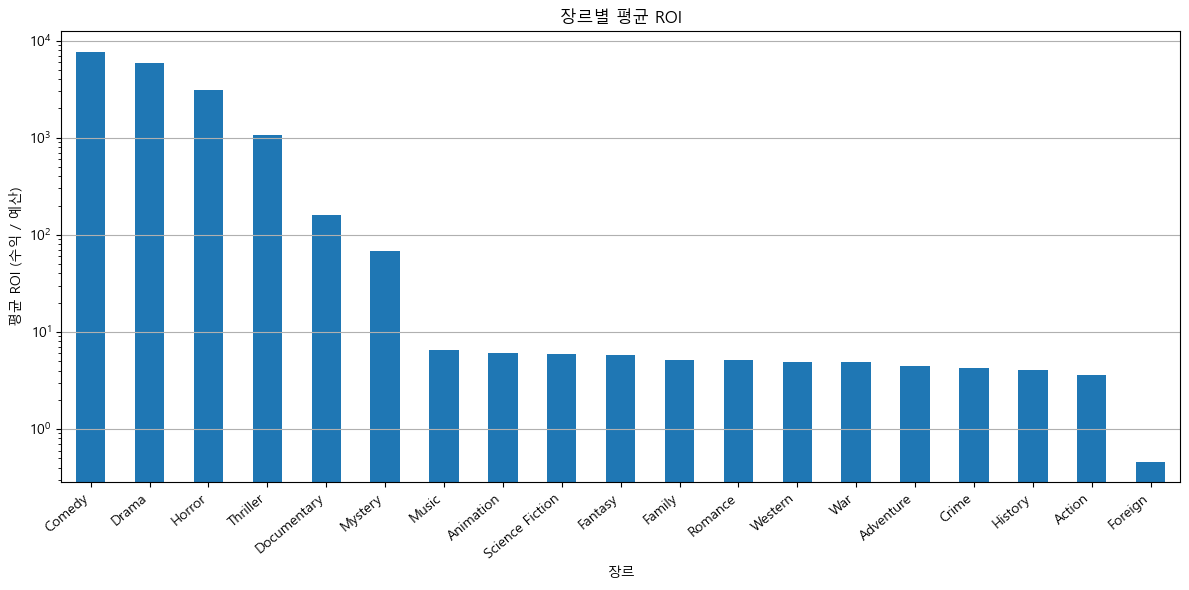

In [24]:
plt.figure(figsize=(12,6))
genre_roi.plot(kind='bar')
plt.title("장르별 평균 ROI")
plt.xlabel("장르")
plt.ylabel("평균 ROI (수익 / 예산)")
plt.xticks(rotation=40, ha='right')
plt.yscale('log') 
plt.tight_layout()
plt.grid(axis='y')
plt.show()

***

## 3) 세번째 이슈 및 개선 내역


In [27]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
sns.set_style("white")
mpl.rc('font',family='Malgun Gothic') 

In [28]:
md = pd.read_csv('tmdb_5000_movies.csv')
md

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
4799,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
4800,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""

### 평점 관련 영화 데이터 전처리

In [30]:
# 평균 평점, 평점 수  null 값 제거
md.dropna(subset=['vote_average', 'vote_count'])

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
4799,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
4800,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""

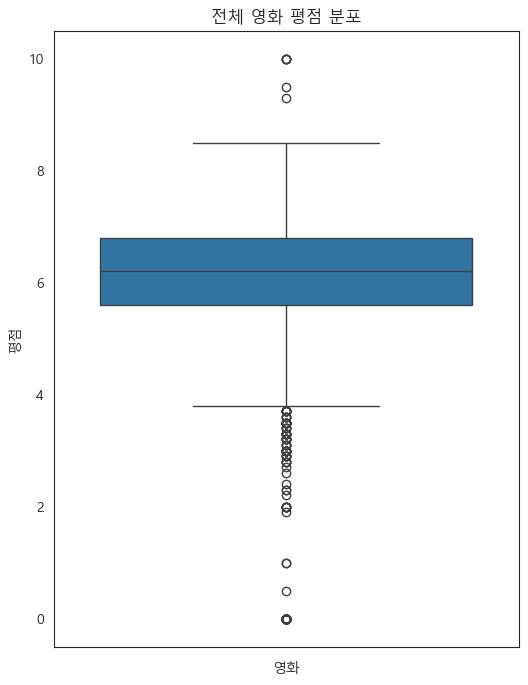

In [31]:
# 영화 데이터의 전체 영화 평점 분포
plt.figure(figsize=(6,8))
sns.boxplot(y=md['vote_average'])
plt.title("전체 영화 평점 분포")
plt.ylabel("평점")
plt.xlabel("영화")
plt.show()

In [32]:
# 사분위수(IQR)를 활용한 이상치 제거
Q1 = md['vote_average'].quantile(0.25)
Q3 = md['vote_average'].quantile(0.75)
IQR = Q3 - Q1
md = md[(md['vote_average'] >= Q1 - 1.5 * IQR) & (md['vote_average'] <= Q3 + 1.5 * IQR)]
md

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
4799,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
4800,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""

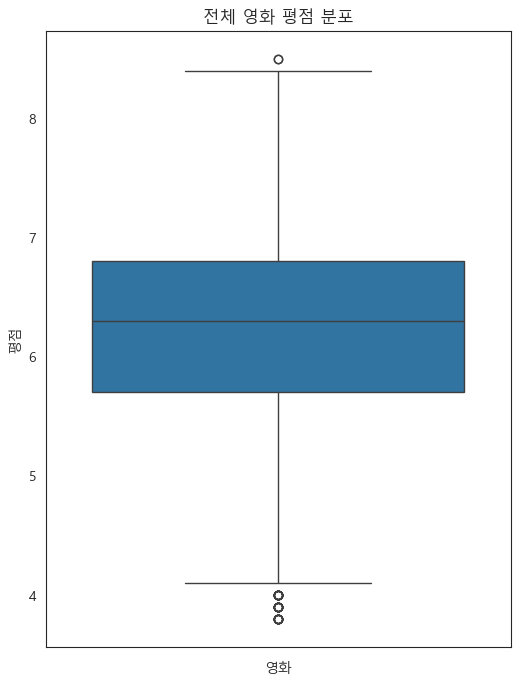

In [33]:
# 이상치 제거 후 전체 영화 평점 분포
plt.figure(figsize=(6,8))
sns.boxplot(y=md['vote_average'])
plt.title("전체 영화 평점 분포")
plt.ylabel("평점")
plt.xlabel("영화")
plt.show()

### 평점 수와 평점 간의 관계

- 피드백 : "같은 평점이어도 평가자 수(관객)가 적으면 그 평점에 대해 신뢰도가 떨어진다고도 생각할 수 있을 것 같은데 데이터에서 평점과의 관계를 보여주실때 사용한 범위의 평가자 수 분포가 비슷한지 알고싶습니다."

- 평가자 수 분포는 각기 다르며 피드백을 참고하여 평점 수에 따라  [20개 미만 -> '매우 낮음', 100개 미만 -> '낮음', 1000개 미만 -> '보통', 1000개 이상 -> '높음] 다음과 같이 평점에 대한 신뢰도를 나눈 뒤 신뢰도에 따라 평점 분포를 파악한 결과
신뢰도가 낮으면 평점 평균이 낮고 분산이 매우 크며 신뢰도가 높으면 평점 평균은 높고 분산이 작은 걸 알 수 있습니다. 따라서 평점갯수가 낮으면 평점 분포가 높은 걸로 보아 신뢰도가 떨어짐을 알 수 있습니다. 결론적으로
평점 개수가 일정 이상 높아야 평점에 대해 신뢰도가 생길 것 같아 평점수를 100개 이상 영화만을 따로 추출하여 데이터 분석을 다시 진행하였습니다.

신뢰도별 평점 개수 : trust
보통       2224
낮음        963
높음        924
매우 낮음     536
Name: count, dtype: int64


C:\Users\jyk95\AppData\Local\Temp\ipykernel_14792\3316190405.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  md['trust'] = md['vote_count'].apply(trust)


Text(0, 0.5, '평점')

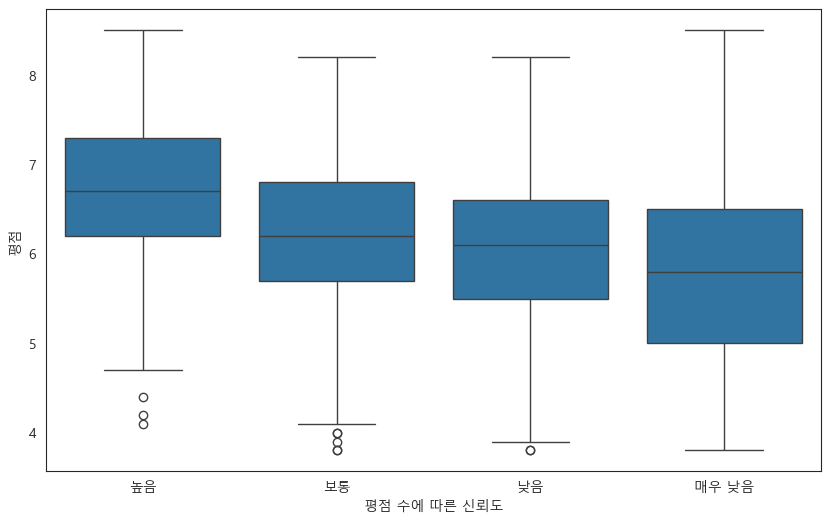

In [36]:
# 20개 미만 -> '매우 낮음', 100개 미만 -> '낮음', 1000개 미만 -> '보통', 1000개 이상 -> '높음'
def trust(a) :
    if a < 20 :
        return '매우 낮음'
    elif a < 100 :
        return '낮음'
    elif a < 1000 :
        return '보통'
    else :
        return '높음'
# 함수 적용    
md['trust'] = md['vote_count'].apply(trust)
print(f'신뢰도별 평점 개수 : {md["trust"].value_counts()}')
plt.figure(figsize=(10,6))
sns.boxplot(x=md['trust'], y = md['vote_average'])
plt.xlabel('평점 수에 따른 신뢰도')
plt.ylabel('평점')

In [37]:
# 100개 이상 투표수로 확립
md = md[md['vote_count'] >= 100]

### 장르별 평균 연도와 연도별 평점 평균 차이 및 연도별 평점 개수

- 피드백 : "역사가 오래된 장르와 그렇지 않은 장르의 평균 평점은 차이가 꽤 날 수도 있을 것 같은데 처음 그래프는 특정 연도를 기준으로 비교하신 건지 궁금합니다."
- 처음 그래프![image.png](attachment:image.png)
- 답변 : 처음 그래프는 특정 년도를 기준으로 비교한 것이 아닌 데이터 전체 년도(1927~2016)에 걸친 영화 데이터 대상으로 각 장르별 평균 평점 분포를 나타낸 것입니다.
피드백 중 역사가 오래된 장르와 그렇지 않은 장르의 평균 평점의 차이가 날 수 있을 것 같아 장르별 평균 평점을 구해보았습니다.

In [40]:
# 년도만 따로 추출, 최저년도와 최고년도 추출
md['release_year'] = pd.to_numeric(md['release_date'].astype(str).str[:4])
print(min(md['release_year']),max(md['release_year']))

1927 2016


C:\Users\jyk95\AppData\Local\Temp\ipykernel_14792\25789281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  md['release_year'] = pd.to_numeric(md['release_date'].astype(str).str[:4])


In [41]:
# 문자열인 장르 칼럼의 값을 리스트로 변환(영화장르별 수익률 분석에서 가져옴)
def parse_genres(genre_str): 
    try:
        genres = ast.literal_eval(genre_str) 
        return [g['name'] for g in genres] 
    except:
        return [] 
    
md["genres_list"] = md["genres"].apply(parse_genres)
# 리스트로 변환된 장르 칼럼의 데이터들을 각각 분리
md_exploded = md.explode('genres_list')
# index 리셋
md = md_exploded.reset_index(drop=True)
md.head(10)

C:\Users\jyk95\AppData\Local\Temp\ipykernel_14792\889758130.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  md["genres_list"] = md["genres"].apply(parse_genres)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,trust,release_year,genres_list
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,높음,2009,Action
1,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,높음,2009,Adventure
2,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,높음,2009,Fantasy
3,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,높음,2009,Science Fiction
4,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,높음,2007,Adventure
5,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,높음,2007,Fantasy
6,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,높음,2007,Action
7,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,

In [42]:
# 장르별 평균년도 추출
genreYear = md.groupby('genres_list')['release_year'].mean()
genreYear = genreYear.reset_index()
genreYear['release_year'] = genreYear['release_year'].round()
genreYear = genreYear.sort_values(by='release_year')

In [43]:
# 장르별 평균년도
genreYear

,genres_list,release_year
15,TV Movie,1995.0
18,Western,1997.0
17,War,1998.0
11,Music,2001.0
9,History,2001.0
14,Science Fiction,2002.0
1,Adventure,2002.0
6,Drama,2003.0
7,Family,2003.0
8,Fantasy,2003.0


Text(0, 0.5, '평균년도')

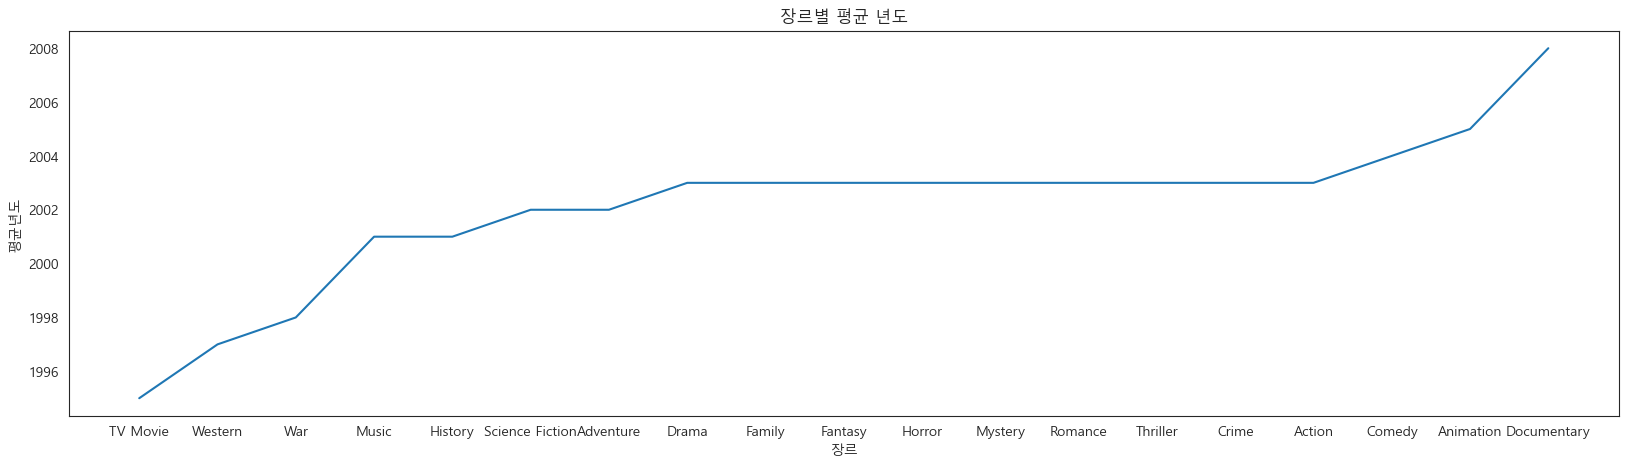

In [44]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=genreYear, x= 'genres_list', y = 'release_year')
plt.title('장르별 평균 년도')
plt.xlabel('장르')
plt.ylabel('평균년도')

-TV Movie, Western, War와 같이 역사가 오래된 장르들은 평균 출시 연도가 낮은(과거) 장르에 해당합니다.
그러나 장르별 평균 평점 분포를 살펴보면, 이들 장르가 다른 장르에 비해 평균 평점이 현저히 높거나 낮은 경향을 보이진 않았습니다.
(다만 TV Movie 장르는 평균 평점이 낮은 경향을 보이긴 했으나, 이는 장르 자체의 특성에 기인한 것으로, '오래된 장르'라는 사실만으로 설명되지는 않을 것으로 보입니다.)
따라서 장르의 역사적 길이(출시 연도)와 평균 평점 간의 차이는 예상보다 크지 않다고 결론지을 수 있습니다.

Text(0, 0.5, '평균 평점')

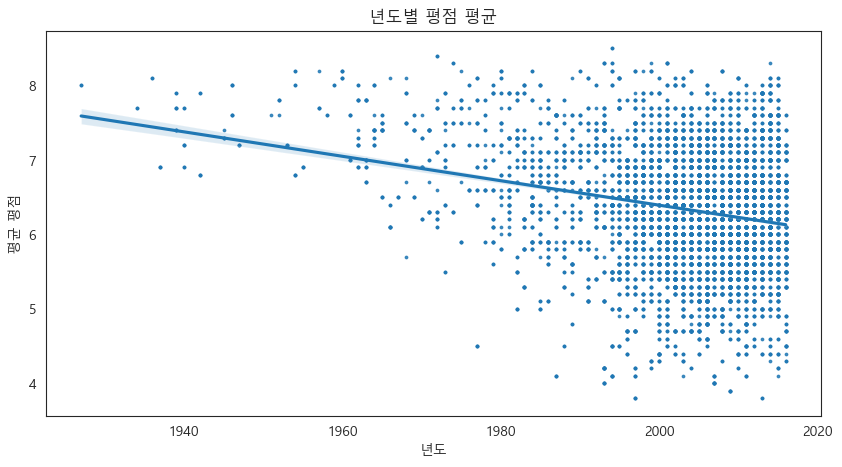

In [46]:
# 년도별 평점 평균 
plt.figure(figsize=(10, 5))
sns.regplot(x='release_year', y = 'vote_average', data = md, scatter_kws = {'s':3})
plt.title('년도별 평점 평균')
plt.xlabel('년도')
plt.ylabel('평균 평점')

Text(0, 0.5, '평점 개수')

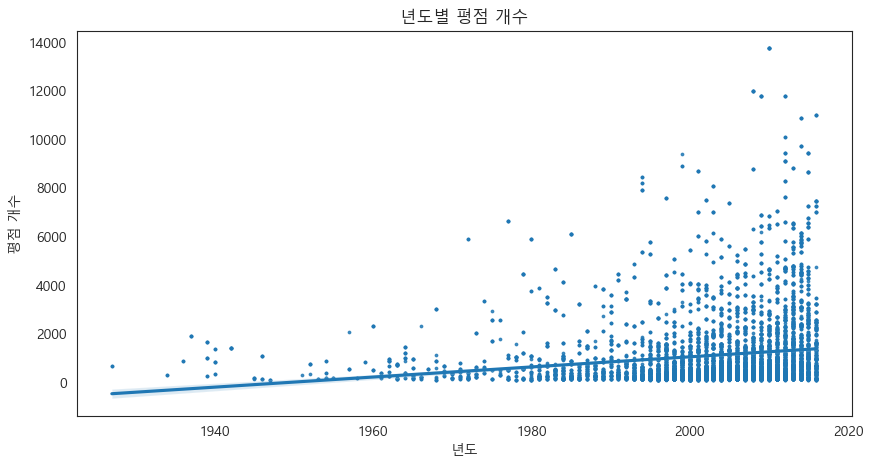

In [47]:
plt.figure(figsize=(10, 5))
sns.regplot(x='release_year', y = 'vote_count', data = md, scatter_kws = {'s':3})
plt.title('년도별 평점 개수')
plt.xlabel('년도')
plt.ylabel('평점 개수')

In [48]:
# 피어슨 상관계수 
md[['release_year','vote_average','vote_count']].corrwith(md.release_year, numeric_only=True, method='pearson')

release_year    1.000000
vote_average   -0.229662
vote_count      0.156751
dtype: float64

추가로, 년도별 평점 개수와 년도별 평균 평점을 분석해보았습니다.
분석 결과, 평균 평점은 과거(오래된) 년도일수록 다소 높은 경향을 보였고, 평점 개수는 최근 년도일수록 다소 많은 경향을 보였습니다.
그러나 Pearson 상관계수로 확인한 결과, 각각 -0.252317 (평균 평점)과 0.134209 (평점 개수)로 나타나, 년도와 이들 변수 간의 상관관계는 뚜렷하게 강하다고 보기는 어려웠습니다.

### 장르와 평점 관계

- 전체 데이터 기준!

Text(0, 0.5, '평균 평점')

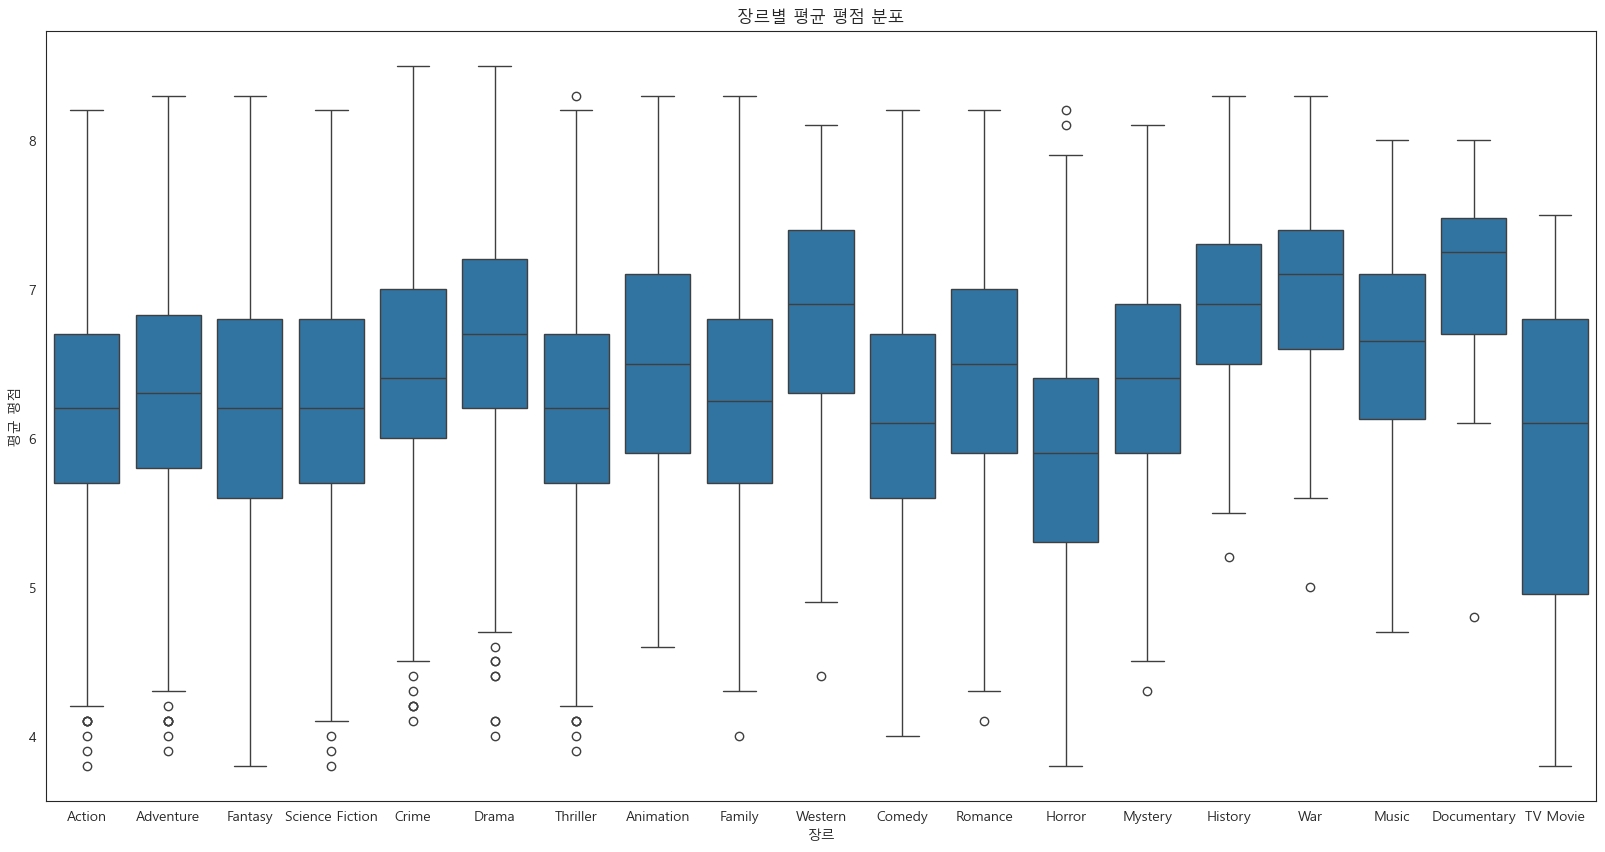

In [51]:
# 장르별로 평균 평점 분포 boxplot을 구함.
plt.figure(figsize=(20, 10))
sns.boxplot(x = 'genres_list', y = 'vote_average', data=md)
plt.title('장르별 평균 평점 분포')
plt.xlabel('장르')
plt.ylabel('평균 평점')

### 장르별 영화 평점 분포

- 주요 분석 포인트
    1. 평균 평점이 높은 장르 : Documentary, History, War, Western
    - 이들 장르는 비판적/심층적 접근이 필요한 장르로 고평가 영향이 있다.
    - 사실성 중심의 영화는 비평가 및 관객으로부터 좋은 평가를 받는 경향이 있음을 보임.

    2. 평균 평점이 낮은 장르 : Tv Movie, Horror, Romance, Comedy
    - Tv Movie는 특히 평점이 낮으며 이는 대부분의 Tv 영화는 제작 예산이 적고 시간 제약이 있는 형식으로 만들어져 연출, 연기, 촬영, CG 등에서 극장 개봉 영화보다 품질이 낮은 경우가 많음.
    - 따라서 평균 평점이 상대적으로 낮게 분포됨

    3. 분포가 매우 큰 장르 : Tv Movie
    - TV Movie 장르는 제작 예산과 품질 편차가 크고, 다양한 포맷(드라마, 다큐 등)이 섞여 있어 작품 간 완성도 차이가 심함.
    - 특정 소수 타깃을 겨냥한 작품이 많아, 평가자의 기대치에 따라 평점이 크게 갈릴 수 있음. 

Text(0, 0.5, '평균 평점')

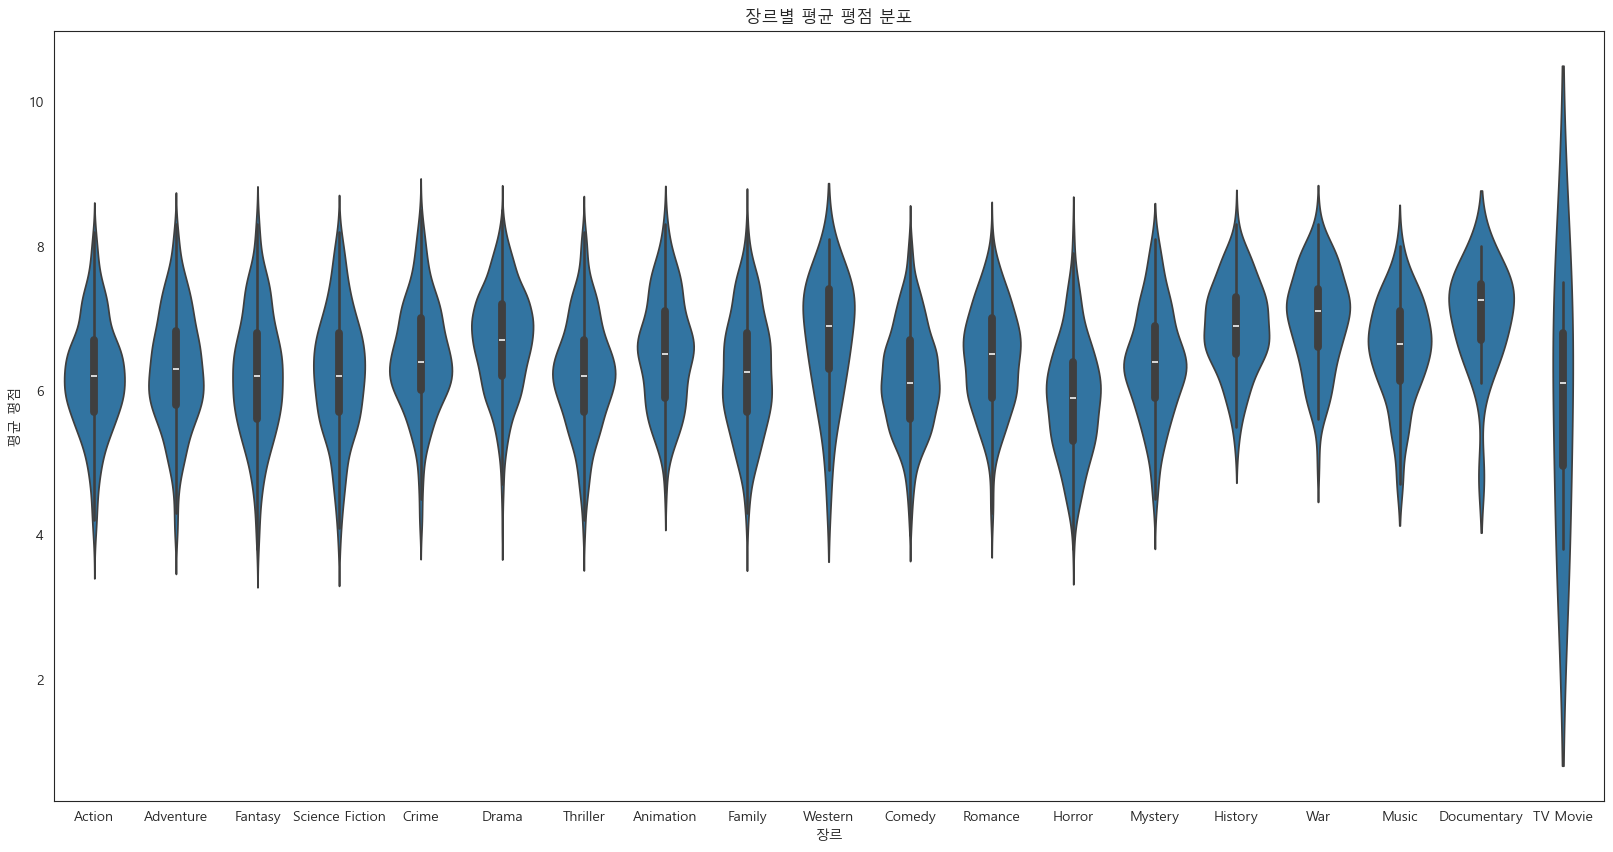

In [53]:
# 장르별로 평균 평점 분포 violinplot을 구함.
plt.figure(figsize=(20, 10))
sns.violinplot(x = 'genres_list', y = 'vote_average', data=md_exploded)
plt.title('장르별 평균 평점 분포')
plt.xlabel('장르')
plt.ylabel('평균 평점')

In [54]:
# 사분위수 Q3을 구함.
md_Q3 = md['vote_average'].quantile(0.75)

In [55]:
# 사분위수 Q3을 구함.
md_Q3 = md['vote_average'].quantile(0.75)

# 평균 평점 상위 25프로 데이터 추출
md25 = md[md['vote_average'] >= md_Q3]
md25

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,trust,release_year,genres_list
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,높음,2009,Action
1,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,높음,2009,Adventure
2,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,높음,2009,Fantasy
3,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,높음,2009,Science Fiction
4,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,높음,2007,Adventure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,60000,"[{""id"": 9648, ""name"": ""Mystery""}, {""id"": 18, ""...",http://www.pithemovie.com/,473,"[{""id"": 2157, ""name"": ""hacker""}, {""id"": 2303, ...",en,Pi,The debut film from Darren Aronofsky in which ...,27.788067,"[{""name"": ""Truth and Soul Pictures Inc"", ""id"":...",...,84.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"There will be no order, only chaos",Pi,7.1,586,보통,1998,Thriller
8429,27000,"[{""id"": 35, ""name"": ""Comedy""}]",http://www.miramax.com/movie/clerks/,2292,"[{""id"": 1361, ""name"": ""salesclerk""}, {""id"": 30...",en,Clerks,Convenience and video store clerks Dante and R...,19.748658,"[{""name"": ""Miramax Films"", ""id"": 14}, {""name"":...",...,92.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Just because they serve you doesn't mean they ...,Clerks,7.4,755,보통,1994,Comedy
8437,7000,"[{""id"": 878, ""name"": ""Science Fiction""}, {""id""...",http://www.primermovie.com,14337,"[{""id"": 1448, ""name"": ""distrust""}, {""id"": 2101...",en,Primer,Friends/fledgling entrepreneurs invent a devic...,23.307949,"[{""name"": ""Thinkfilm"", ""id"": 446}]",...,77.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,What happens if it actually works?,Primer,6.9,658,보통,2004,Science Fiction
8438,7000,"[{""id"": 878, ""name"": ""Science Fiction""}, {""id""...",http://www.primermovie.com,14337,"[{""id"": 1448, ""nam

Text(0, 0.5, '상위 25% 영화 수')

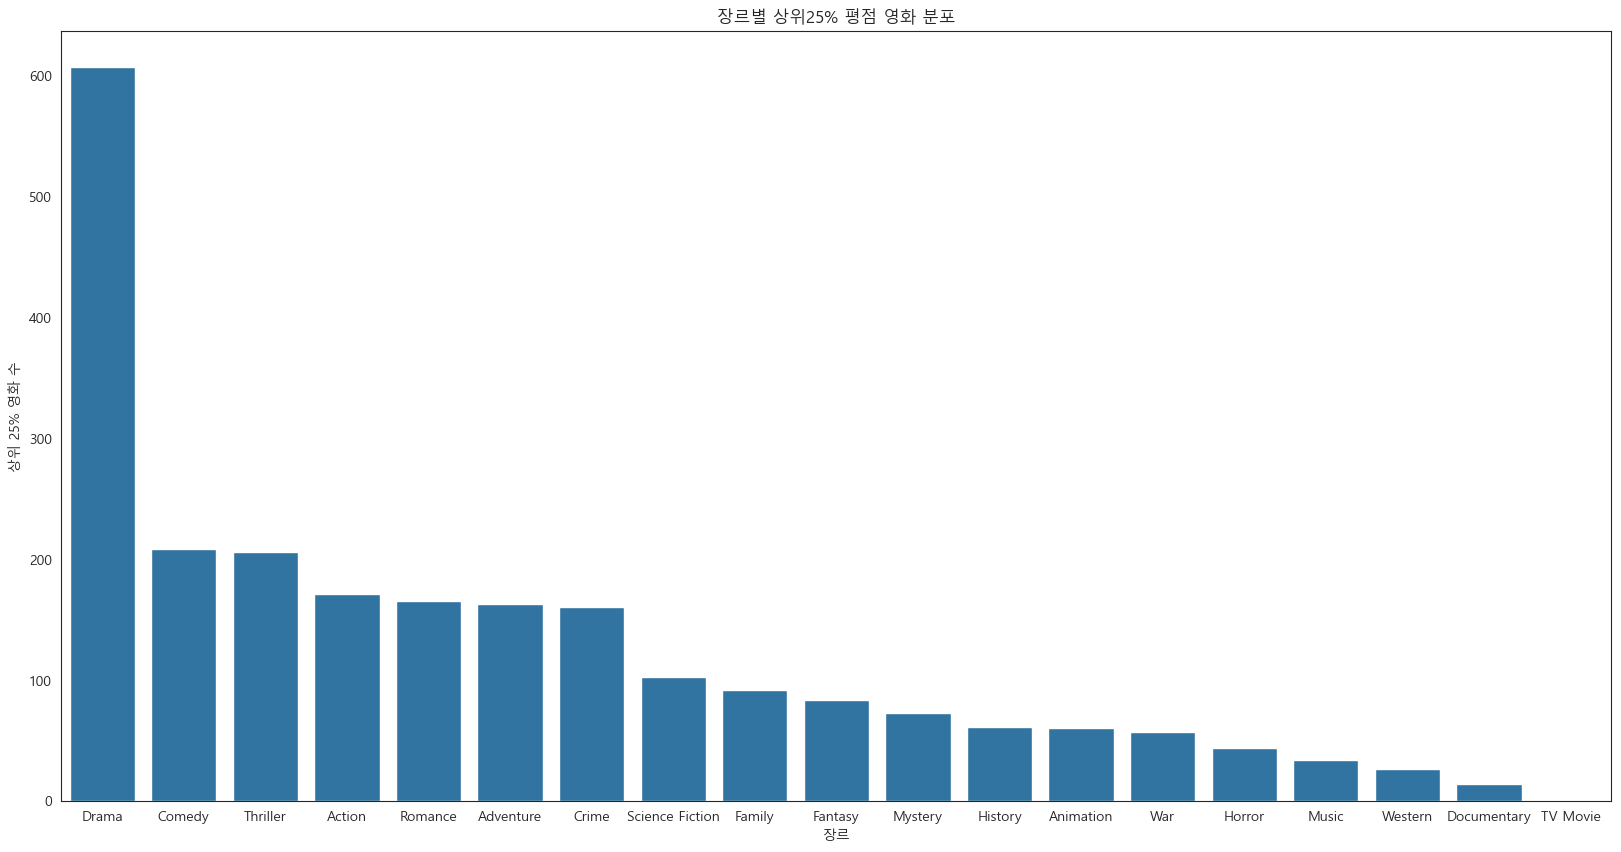

In [56]:
# 장르별 상위 25% 평균 평점 영화 분포를 countplot으로 구함.
plt.figure(figsize=(20, 10))
# 내림차순 정렬을 위한 인덱스 리스트 추출
genre_order = md25['genres_list'].value_counts().index
sns.countplot(data=md25, x = 'genres_list', order = genre_order)
plt.title('장르별 상위25% 평점 영화 분포')
plt.xlabel('장르')
plt.ylabel('상위 25% 영화 수')

- 분석 포인트

1. Drama가 압도적으로 많다.
    - 이는 드라마 장르가 비평가나 관객에게 긍정적인 평가를 받는 경우가 많다는 의미로 해석
    - Drama의 표본이 매우 많아서 이러한 그래프가 나온 것일 수도 있음.
    
2. Comedy, Thriller, Romance, Action 등 상위권
    - 이 장르들은 상위 평점에서도 비교적 좋은 성과를 보임.
    - 흥행이나 대중성이 있는 장르.

 3. Fantasy, Animation, Documentary 등은 상대적으로 하위권
    - 판타지, 애니메이션, 다큐멘터리 등은 상대적으로 적음. 


## 4) 네번째 이슈 및 개선 내역

- 피드백 : "전체에서 평점 상위 25%를 선별해서 구했을 때, 장르의 특성 상 드라마 장르의 영화 수가 많아서 드라마 장르가 압도적으로 높다는 결론 및 주의점을 드러내셨는데, 그렇다면 전체 장르 별 개수에 대한 상위 25% 개수 이렇게 해서 비율로 구하는 게 더 적합한 비교였지 않을까 궁금합니다."
- 답변 : 피드백 주신 내용에 적극 동의하는 바입니다. 단순히 상위 25% 영화 수를 비교하면 드라마와 같이 원래 작품 수가 많은 장르가 상대적으로 유리하기 때문에 각 장르별 전체 작품 수 대비 상위 25%에 해당하는 작품 비율을 계산하는 것이 더 정확한 비교 방법인 것 같습니다.
다음은 상위 25%에 해당하는 작품 비율을 계산하여 barplot으로 구해보았습니다.

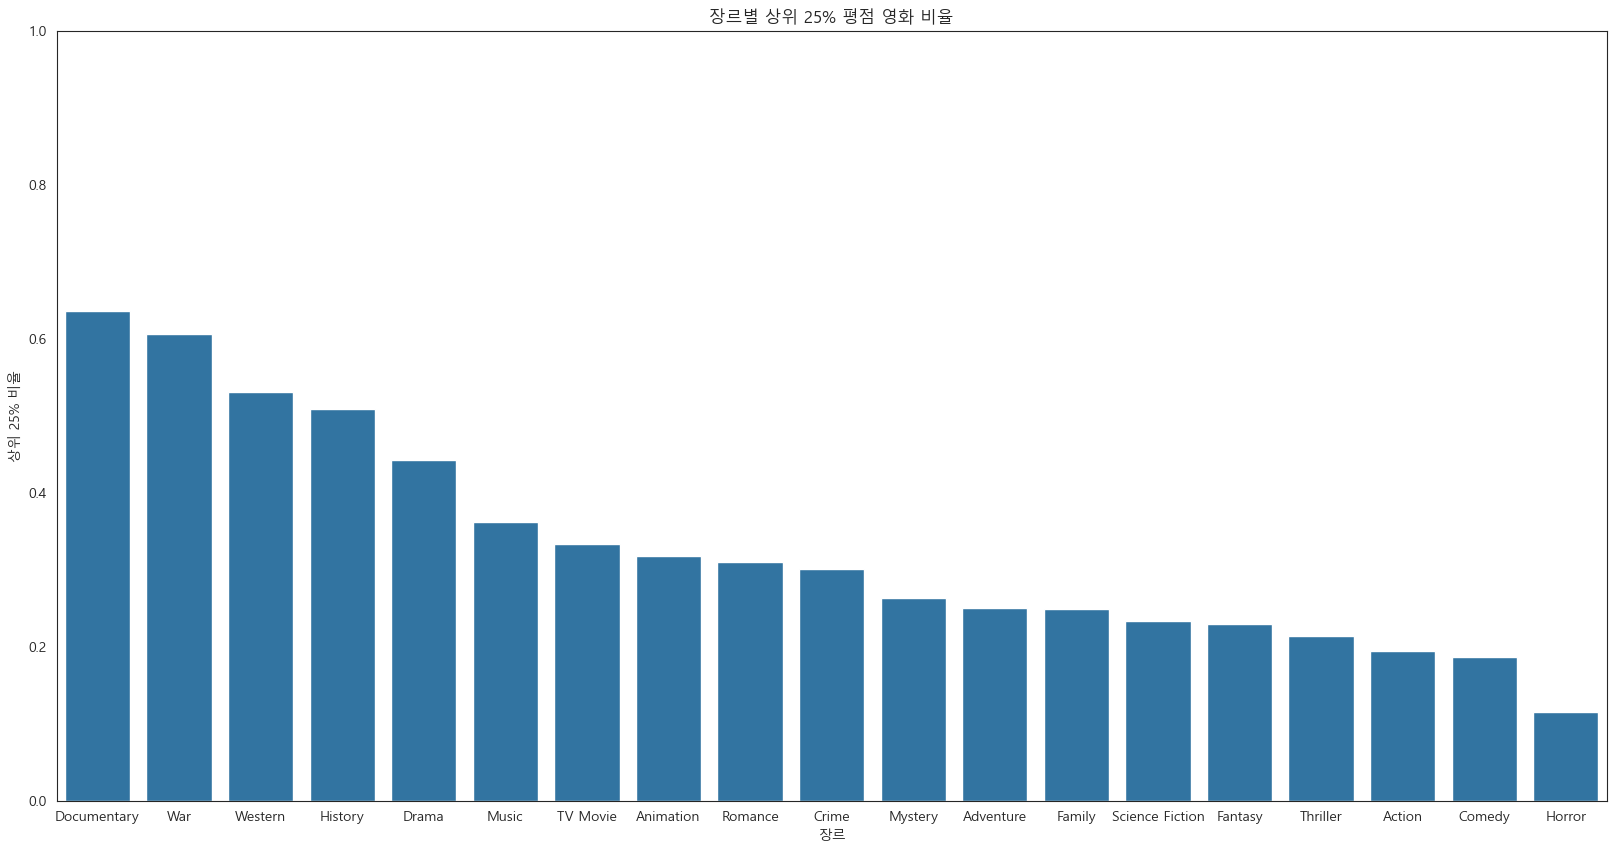

In [59]:
# 전체 데이터 비율
md_counts = md['genres_list'].value_counts()
# 상위 25% 데이터 비율
md25_counts = md25['genres_list'].value_counts()
# 전체 데이터 대비 상위 25% 데이터 비율(+sort)
md_ratio = (md25_counts / md_counts).sort_values(ascending=False)

plt.figure(figsize=(20, 10))
sns.barplot(x=md_ratio.index, y = md_ratio.values)

plt.xlabel('장르')
plt.ylabel('상위 25% 비율')
plt.title('장르별 상위 25% 평점 영화 비율')
# 비율이기에 0과 1로 범위를 잡음
plt.ylim(0, 1)
plt.show()

- 분석 포인트

1. 상위권 장르
    - Documentary, War, Western 장르가 상위권을 차지하고 있음.
    - 이 장르들은 전체 영화 수 대비 상위 25% 평점에 해당하는 영화 비율이 매우 높다. (약 60~65%)
    - 사실성, 역사성, 심층성을 중요하게 다루는 장르 특성상, 관객과 평론가에게 좋은 평가를 받을 가능성이 크다는 것을 보여줌.

2. 중위권 장르
    - History, Drama, Music, TV Movie, Animation, Romance, Crime 등이 중간에 위치
    - 특히 Drama는 전체 수가 많음에도 불구하고 꽤 높은 상위 25% 비율을 보여서, 작품 간 편차가 있음에도 일정 수준 이상의 좋은 평가를 받는 작품 수가 많은 장르임을 나타냄.

3. 하위권 장르
    - Action, Comedy, Horror는 상위 25%에 속하는 영화 비율이 매우 낮음. (0.2 이하)
    - 이 장르들은 대중성은 높지만, 작품성 측면에서는 고평가를 받기 어렵다는 경향을 보여줌.

4. boxplot과의 차이점
    - Tv movie 장르는 boxplot에서는 평균 평점이 낮은 장르. 그러나 위 그래프에서는 상위 25% 비율이 중위권에 해당하여, 예상보다 좋은 평가를 받은 영화 비율이 높게 나타남. 이는 Tv movie 장르 내에서 전반적으로 평균 평점은 낮지만, 소수의 작품이 높은 평가를 받아 분포를 끌어올림을 의미.
    - Horror 장르는 boxplot에서도 평균 평점이 낮고, barplot에서도 상위 25% 비율이 가장 낮은 편으로 나타나, 두 그래프 모두 일관되게 낮은 평가 경향을 보여줌.
    - Drama 장르는 boxplot에서는 평균 평점이 보통 수준이었지만, barplot에서는 비교적 높게 나타나 전체 영화 수가 많음에도 불구하고 일정 수준 이상의 고평가 작품이 많이 포함되어 있음을 알 수 있음.

***

## 5) 다섯번째 이슈 및 개선 내역


### 장르별 작품 수, 영화시장의 규모(예산) 분석

Text(0, 0.5, '영화 수')

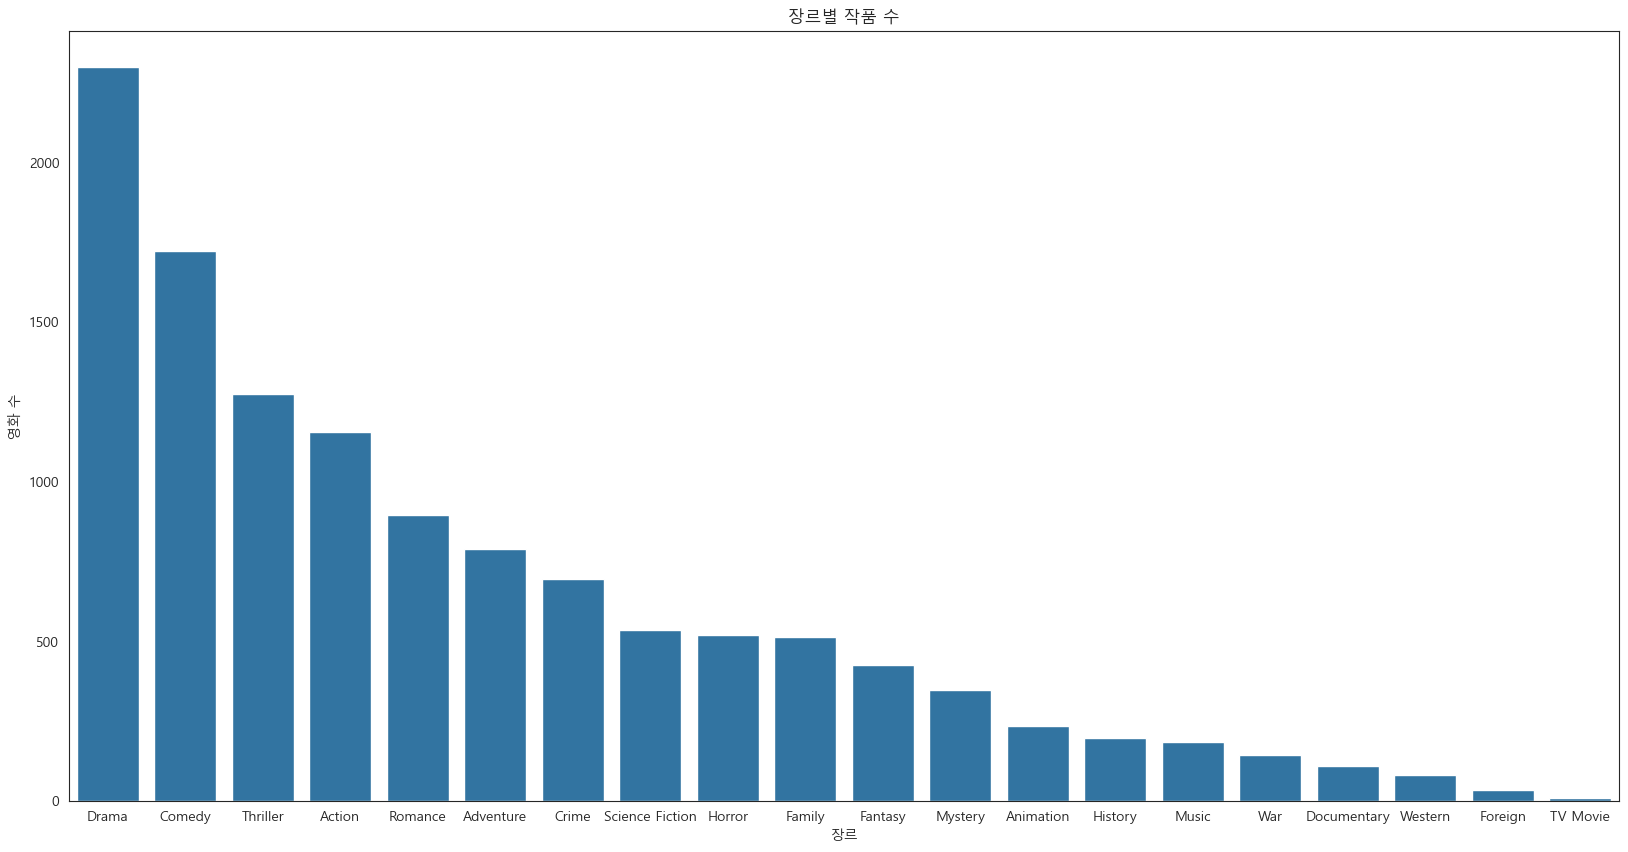

In [64]:
nd = pd.read_csv('tmdb_5000_movies.csv')

# 데이터 전처리
nd.dropna()

# 문자열인 장르 칼럼의 값을 리스트로 변환(영화장르별 수익률 분석에서 가져옴)
def parse_genres(genre_str): 
    try:
        genres = ast.literal_eval(genre_str) 
        return [g['name'] for g in genres] 
    except:
        return [] 
    
nd["genres_list"] = nd["genres"].apply(parse_genres)
# 리스트로 변환된 장르 칼럼의 데이터들을 각각 분리
nd_exploded = nd.explode('genres_list')
# index 리셋
nd = nd_exploded.reset_index(drop=True)

# 장르별 상위 25% 평균 평점 영화 분포를 countplot으로 구함.
plt.figure(figsize=(20, 10))
# 내림차순 정렬을 위한 인덱스 리스트 추출
nd_order = nd['genres_list'].value_counts().index
sns.countplot(data=nd, x = 'genres_list', order = nd_order)
plt.title('장르별 작품 수')
plt.xlabel('장르')
plt.ylabel('영화 수')

revenue    0.791988
dtype: float64


Text(0, 0.5, '수익')

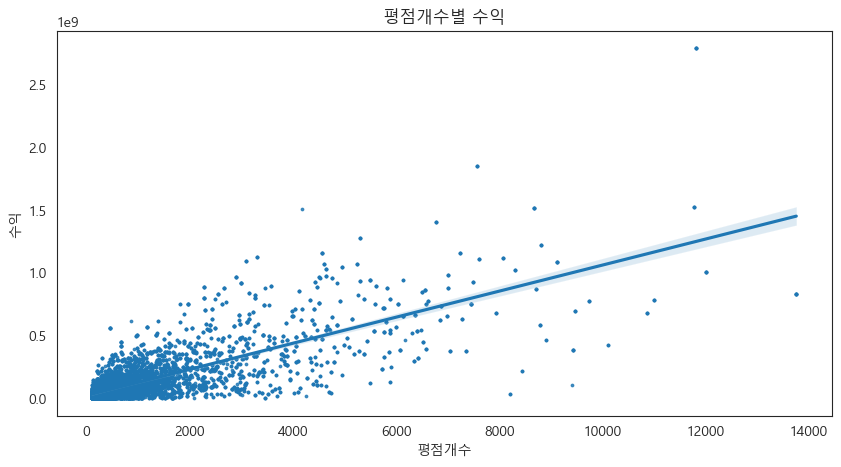

In [65]:
print(nd[['revenue']].corrwith(nd.vote_count))
# 평점개수별 수익 
plt.figure(figsize=(10, 5))
sns.regplot(x='vote_count', y = 'revenue', data = md, scatter_kws = {'s':3})
plt.title('평점개수별 수익')
plt.xlabel('평점개수')
plt.ylabel('수익')

- 이 그래프와 피어슨 상관관계를 보아 수익과 평점개수는 높은 수치로 비례한다는 것을 알 수 있다. 즉 영화관람객이 많을수록 수익과 평점개수는 많아진다는 것을 알 수 있다.

Text(0.5, 1.0, '장르별 평점개수')

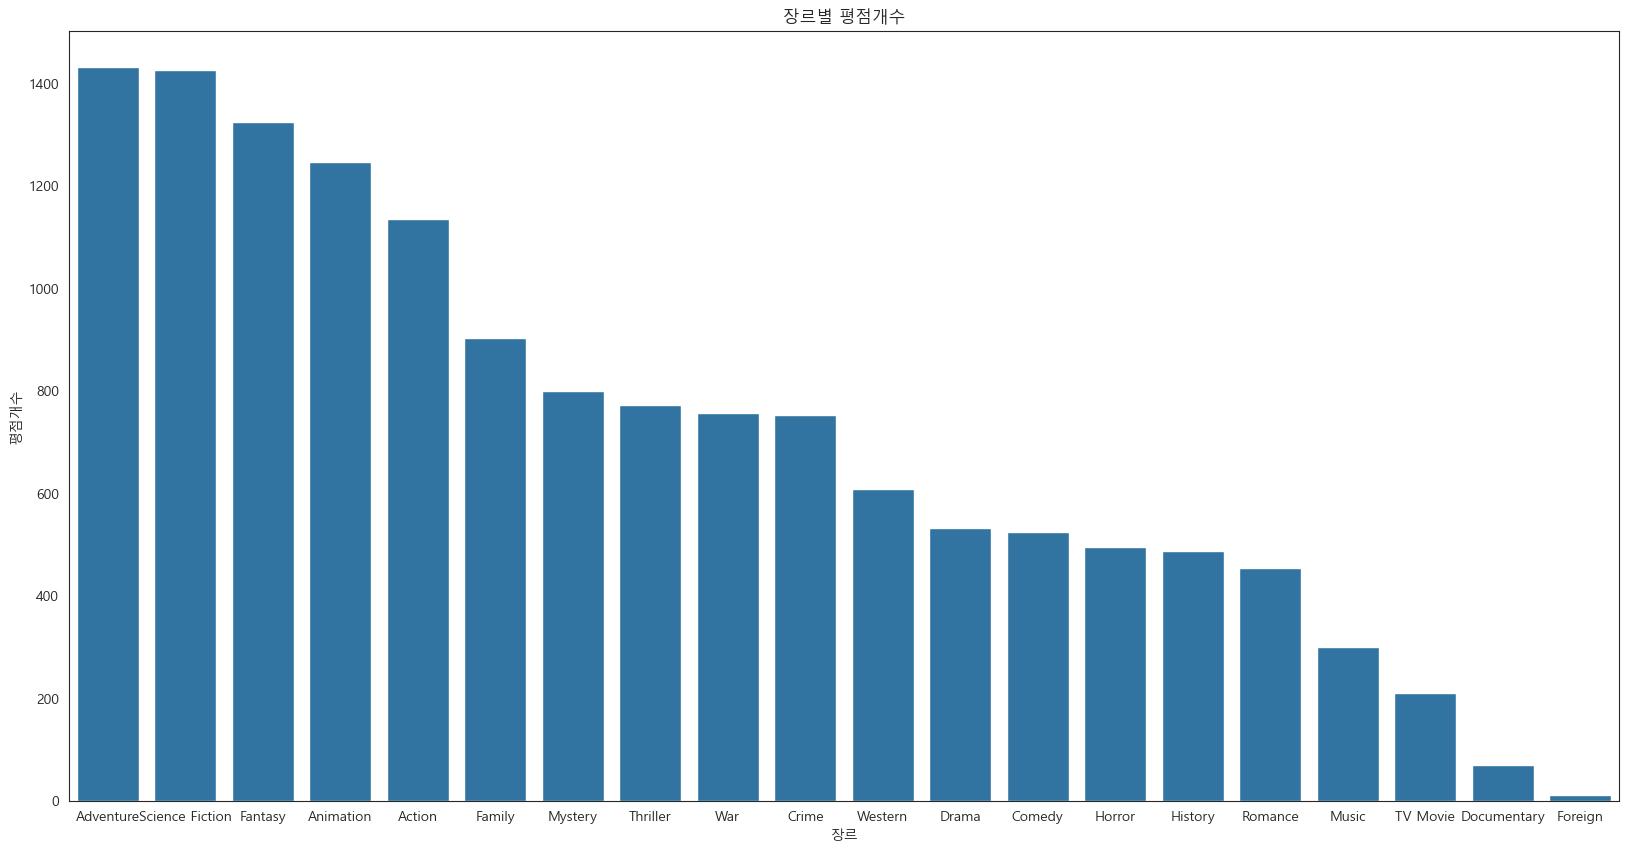

In [67]:
nd_voteCounts = nd.groupby('genres_list')['vote_count'].mean()
nd_voteCounts = nd_voteCounts.sort_values(ascending=False)
plt.figure(figsize=(20, 10))
sns.barplot(x=nd_voteCounts.index, y = nd_voteCounts.values)

plt.xlabel('장르')
plt.ylabel('평점개수')
plt.title('장르별 평점개수')
# 비율이기에 0과 1로 범위를 잡음

Text(0.5, 1.0, '장르별 투자규모')

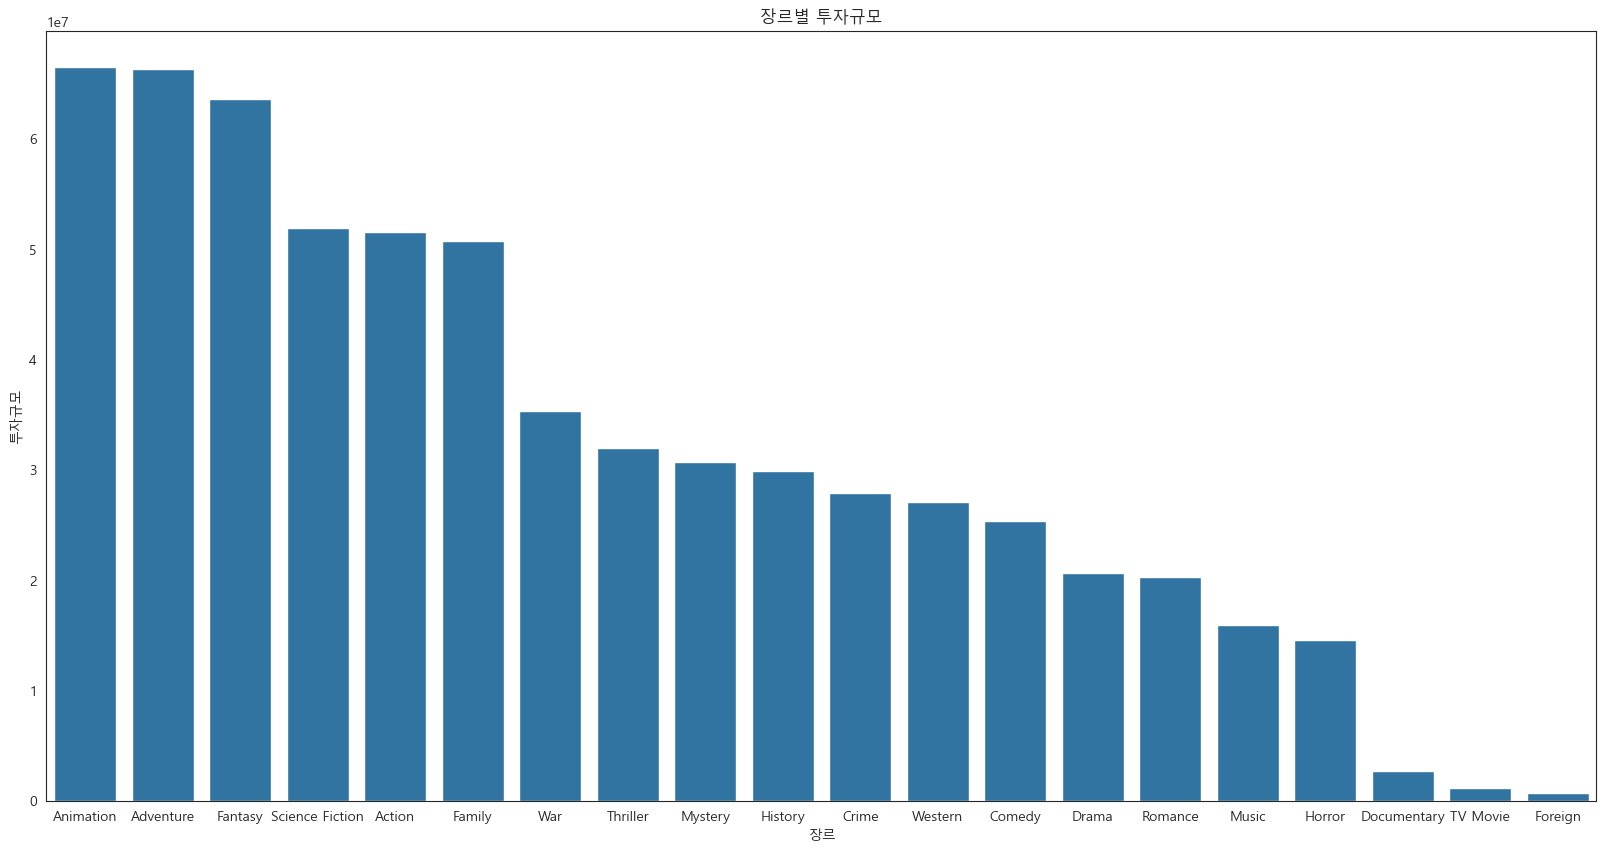

In [68]:
nd_budget= nd.groupby('genres_list')['budget'].mean()
nd_budget = nd_budget.sort_values(ascending=False)
plt.figure(figsize=(20, 10))
sns.barplot(x=nd_budget.index, y = nd_budget.values)

plt.xlabel('장르')
plt.ylabel('투자규모')
plt.title('장르별 투자규모')
# 비율이기에 0과 1로 범위를 잡음

Text(0.5, 1.0, '장르별 투자규모')

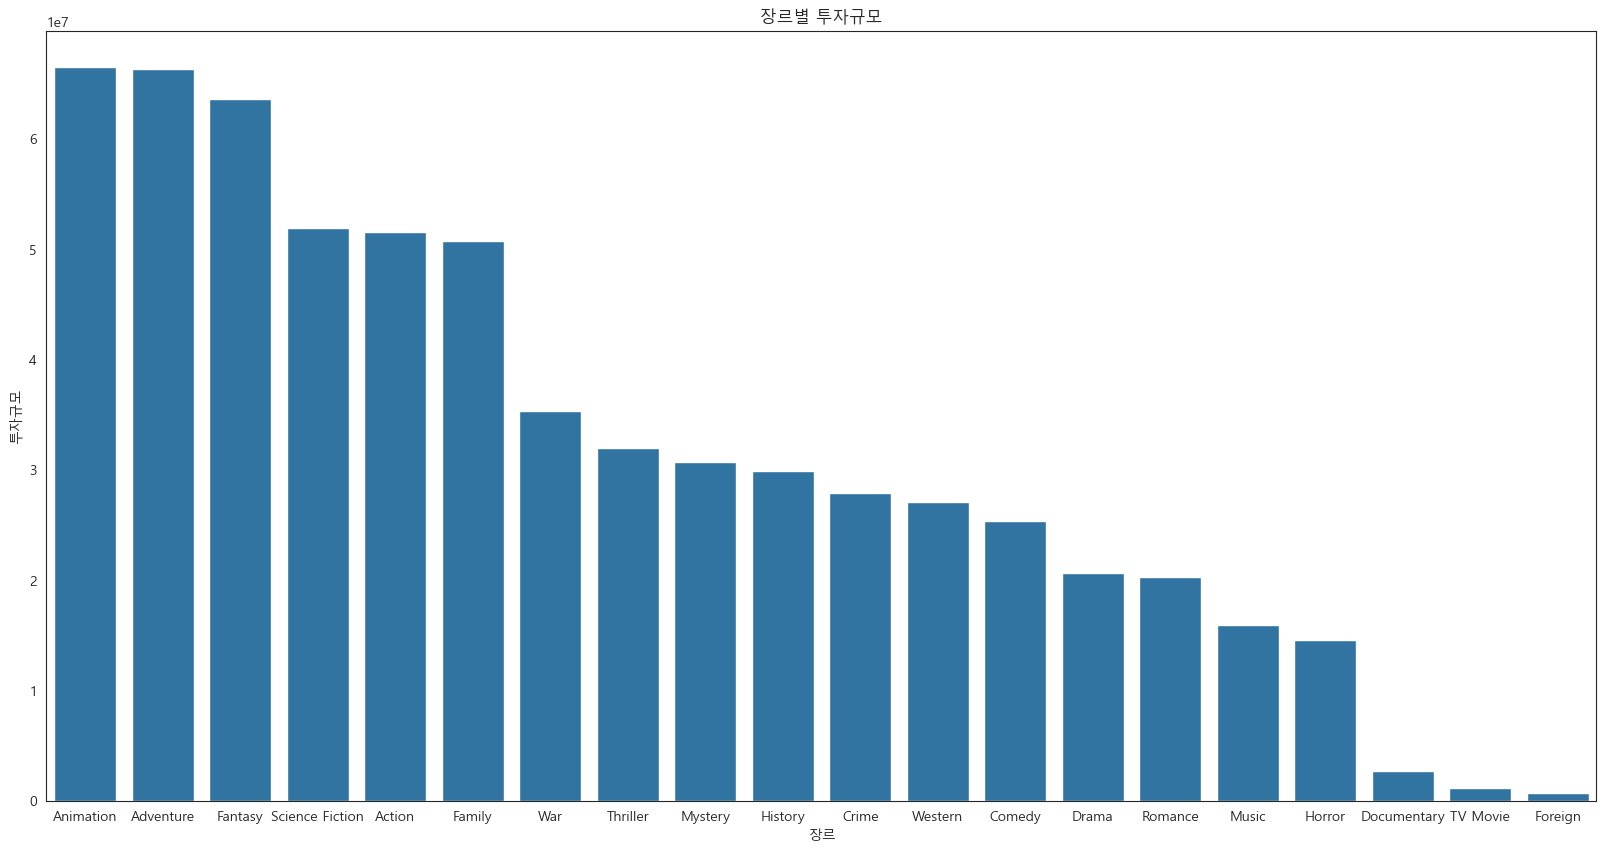

In [69]:
nd_budget= nd.groupby('genres_list')['budget'].mean()
nd_budget = nd_budget.sort_values(ascending=False)
plt.figure(figsize=(20, 10))
sns.barplot(x=nd_budget.index, y = nd_budget.values)

plt.xlabel('장르')
plt.ylabel('투자규모')
plt.title('장르별 투자규모')
# 비율이기에 0과 1로 범위를 잡음

### 월별 장르별 관객수 분포

<Figure size 1200x600 with 0 Axes>

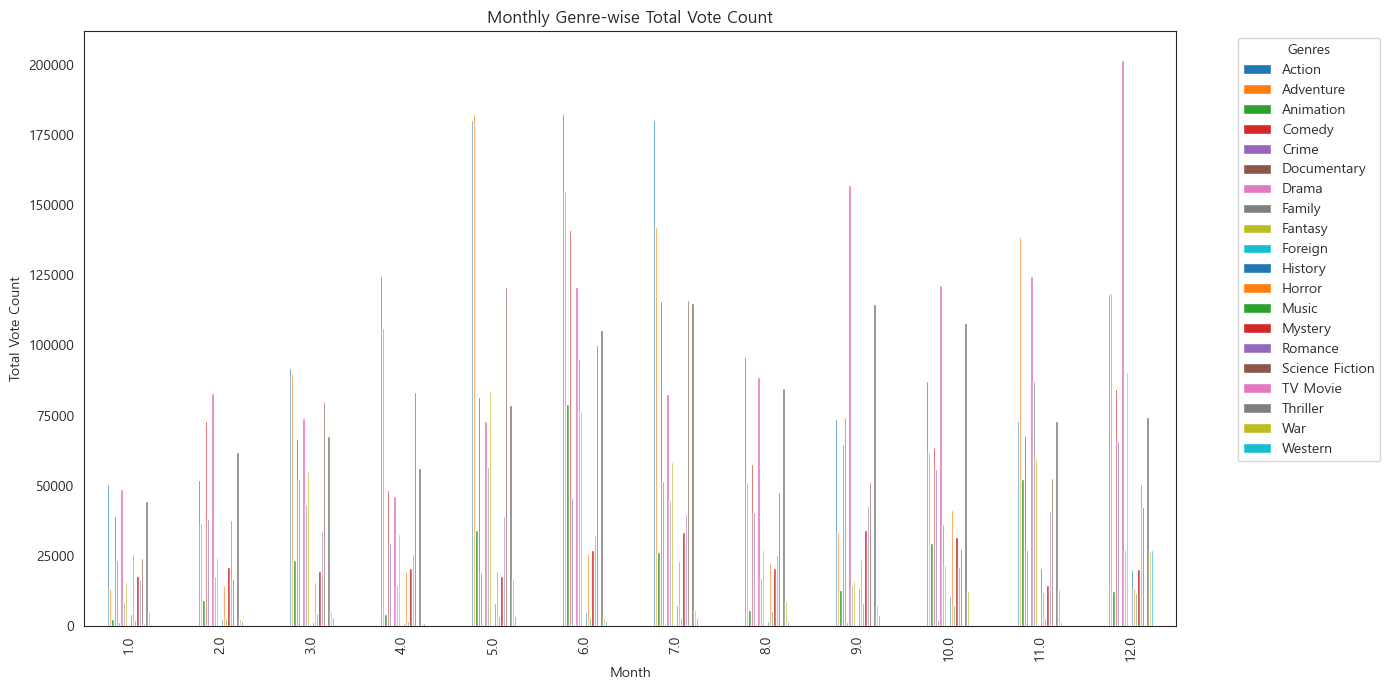

In [71]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl 

movie_data = pd.read_csv('tmdb_5000_movies.csv')

movie_data['release_date'] = pd.to_datetime(movie_data['release_date'], errors='coerce')
movie_data['month'] = movie_data['release_date'].dt.month


movie_data['genres'] = movie_data['genres'].apply(lambda x: [genre['name'] for genre in eval(x)]) # 문자열 리스트에서 장르 추출
genre_data = movie_data.explode('genres') # 장르별로 한 행씩 분리하여 여러 장르를 하나의 행으로 확장
genre_monthly_votes = genre_data.groupby(['month', 'genres'])['vote_count'].sum().reset_index() # 월별로 장르별 투표 수 합산
genre_pivot = genre_monthly_votes.pivot(index='month', columns='genres', values='vote_count').fillna(0) # 피벗 테이블로 변환하여 장르별 월별 투표 수로 변환

plt.figure(figsize=(12, 6))
genre_pivot.plot(kind='bar', stacked=False, figsize=(14, 7))
plt.title('Monthly Genre-wise Total Vote Count')
plt.xlabel('Month')
plt.ylabel('Total Vote Count')
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [72]:
total_vote = movie_data['vote_count'].count()
print(total_vote)

4803


In [73]:
data_exploded
d25=data_exploded['vote_count'].quantile(0.25)
d75=data_exploded['vote_count'].quantile(0.75)
data_filt=data_exploded[(data_exploded['vote_count']>=d25)&(data_exploded['vote_count']<=d75)]
data_filt['release_date']=pd.to_datetime(data_filt['release_date'])
data_filt['month']=data_filt['release_date'].dt.month
data_filt

C:\Users\jyk95\AppData\Local\Temp\ipykernel_14792\372663267.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filt['release_date']=pd.to_datetime(data_filt['release_date'])
C:\Users\jyk95\AppData\Local\Temp\ipykernel_14792\372663267.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filt['month']=data_filt['release_date'].dt.month


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,genre_list,roi,month
4238,1,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...",NaN,3082,"[{""id"": 1382, ""name"": ""factory""}, {""id"": 1546,...",en,Modern Times,The Tramp struggles to live in modern industri...,28.276480,"[{""name"": ""United Artists"", ""id"": 60}, {""name""...",...,87.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,He stands alone as the greatest entertainer of...,Modern Times,8.1,856,Comedy,8.500000e+06,2
4238,1,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...",NaN,3082,"[{""id"": 1382, ""name"": ""factory""}, {""id"": 1546,...",en,Modern Times,The Tramp struggles to live in modern industri...,28.276480,"[{""name"": ""United Artists"", ""id"": 60}, {""name""...",...,87.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,He stands alone as the greatest entertainer of...,Modern Times,8.1,856,Drama,8.500000e+06,2
4496,60000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 9648, ""n...",http://www.blairwitch.com/,2667,"[{""id"": 616, ""name"": ""witch""}, {""id"": 3392, ""n...",en,The Blair Witch Project,In October of 1994 three student filmmakers di...,41.690578,"[{""name"": ""Artisan Entertainment"", ""id"": 2188}...",...,81.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The scariest movie of all time is a true story.,The Blair Witch Project,6.3,1055,Horror,4.133333e+03,7
4496,60000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 9648, ""n...",http://www.blairwitch.com/,2667,"[{""id"": 616, ""name"": ""witch""}, {""id"": 3392, ""n...",en,The Blair Witch Project,In October of 1994 three student filmmakers di...,41.690578,"[{""name"": ""Artisan Entertainment"", ""id"": 2188}...",...,81.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The scariest movie of all time is a true story.,The Blair Witch Project,6.3,1055,Mystery,4.133333e+03,7
4724,10000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 14, ""name...",NaN,985,"[{""id"": 1009, ""name"": ""baby""}, {""id"": 1852, ""n...",en,Eraserhead,Henry Spencer tries to survive his industrial ...,20.399578,"[{""name"": ""American Film Institute (AFI)"", ""id...",...,89.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Where your nightmares end...,Eraserhead,7.5,485,Horror,7.000000e+02,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3399,6000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...",http://www.theboondocksaints.com,8374,"[{""id"": 1679, ""name"": ""arbitrary law""}, {""id"":...",en,The Boondock Saints,With a God-inspired moral obligation to act ag...,34.917447,"[{""name"": ""Franchise Pictures"", ""id"": 1403}, {...",...,108.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Thy Kingdom Come. Thy Will Be Done.,The Boondock Saints,7.2,837,Thriller,5.078500e-03,1
3399,6000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...",http://www.theboondocksaints.com,8374,"[{""id"": 1679, ""name"": ""arbitrary law""}, {""id"":...",en,The Boondock Saints,With a God-inspired moral obligation to act ag...,34.917447,"[{""name"": ""Franchise Pictures"", ""id"": 1403}, {...",...,108.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Thy Kingdom Come. Thy Will Be Done.,The Boondock Saints,7.2,837,Action,5.078500e-03,1
3399,6000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...",http://www.theboondocksaints.com,8374,"[{""id"": 1679, ""name"": ""arbitrary law""}, {""id"":...",en,The Boondock Saints,With a God-inspired moral obligation to act ag...,34.917447,"[{""name"": ""Franchise Pictures"", ""id"": 1403}, {...",...,108.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Thy Kingdom Come. Thy Will Be Done.,The Boondock Saints,7.2,837,Crime,5.078500e-03,1
2068,9000000,"[{""id"": 

In [74]:
data_filt['genre_list']=data_filt['genres'].apply(parse_genres)
data_filt=data_filt.explode('genre_list')

C:\Users\jyk95\AppData\Local\Temp\ipykernel_14792\1464921819.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filt['genre_list']=data_filt['genres'].apply(parse_genres)


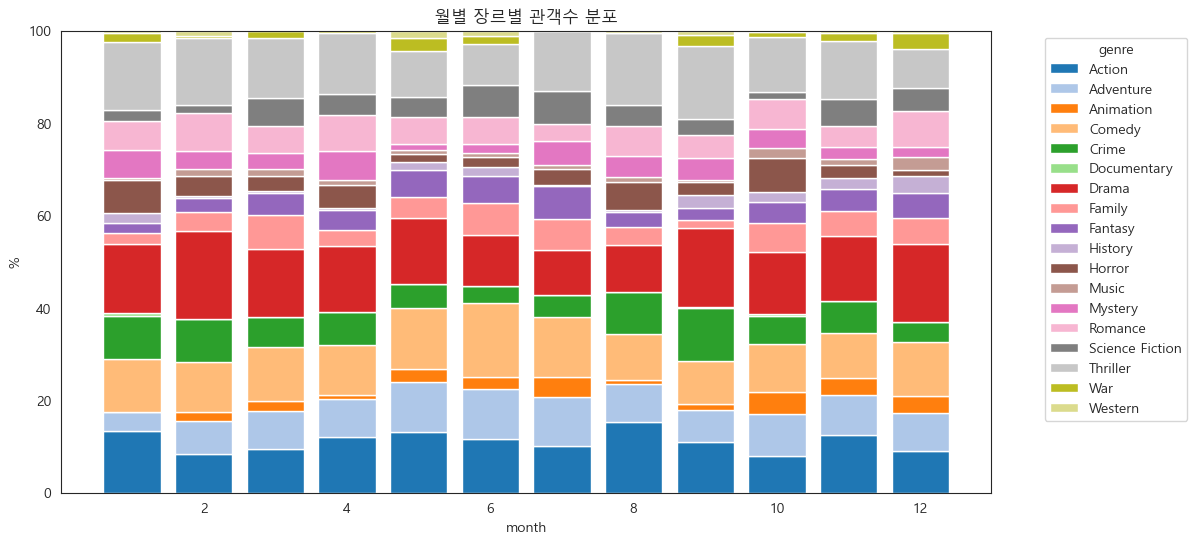

In [84]:
vote_month = data_filt.groupby(['month', 'genre_list'])['vote_count'].sum().reset_index()
total_vote = vote_month.groupby('month')['vote_count'].transform('sum')
vote_month['pct'] = vote_month['vote_count'] / total_vote * 100
pivot = vote_month.pivot(index='month', columns='genre_list', values='pct').fillna(0)
palette = sns.color_palette('tab20', n_colors=len(pivot.columns))
fig, ax = plt.subplots(figsize=(12, 6))
bot = pd.Series([0] * len(pivot), index=pivot.index)
for genre, color in zip(pivot.columns, palette):
    ax.bar(pivot.index, pivot[genre], bottom=bot, label=genre, color=color)
    bot += pivot[genre]
ax.set_ylabel('%')
ax.set_xlabel('month')
ax.legend(title='genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('월별 장르별 관객수 분포')
plt.show()

- 참고 문헌 : 
https://wikidocs.net/book/7188(Pandas DataFrame 완전정복)
https://codevang.tistory.com/338(조건문으로 데이터 넣기)
https://hazel01.tistory.com/34(Datetime() 한번에 정리)

***

## ※ 개선 과정에서 배운 점
(팀원별로 각각 작성)

심우석
- ROI값을 분석하는 과정에서, 다른 값들과 극단적으로 차이나는 이상치가 있었음에도 불구하고, 이를 제거하거나 확인해보는 시도를 하지 않았다. 데이터를 분석할 때 아웃라이어를 제거하는 것을 강의시간에 배웠는데, 실제로 프로젝트를 하는 과정에서 이를 생각하지 않은 것은 큰 실수였던것 같다. 이상치 하나가 데이터 전체를 흐려, 코미디의 평균 수익률이 월등히 높아지게 되었고, 결과적으로 다른 데이터끼리 비교하는 것 조차 의미없을 정도의 큰 오류가 나게 되었다. 이번 프로젝트를 하며 데이터를 분석 할 때 이상치의 중요성에 대해 뼈저리게 알게 되었다.

이도원
- 사람들의 다양한 피드백을 통해 기존 시각화 그래프의 한계점을 파악하고 이를 수정할 수 있었으며, 기존 그래프의 문제점을 보완한 새로운 그래프도 만들 수 있어 매우 유익한 경험이었다. 특히 장르별 상위 25% 평점 영화 수 분포도에서 ‘Drama’ 장르가 전체 영화 수가 많아 그래프가 매우 높은 수치를 띄웠는데 온라인 피드백을 통해 장르별 전체 작품 수 대비 상위 25%에 해당하는 작품 비율로 그래프를 수정한 결과, 완전히 다른 결과가 나와 놀라웠다. 한편으로는 해당 그래프의 문제점을 오랜 시간 고민하고 스스로 수정했다면 더 나은 결과를 얻을 수 있지 않았을까 하는 아쉬움도 남았다. 이번 경험을 통해 앞으로 데이터 시각화를 할 때 그래프의 문제점을 꾸준히 찾아내고, 이를 해결하는 방법을 적극적으로 고민하며 수정해나가야겠다는 다짐을 하게 되었다.

우윤형
- 보완 과정에서 ROI 값을 정상적으로 도출하기 위해 이변값을 제거하는 과정이 필요하였는데 수익률 같은 경우 비율이기 때문에 이변값이 아니더라도 비교적 다양한 범위의 값이 도출될 수 있었다. 따라서 역대 영화들의 최고 수익률을 조사하는 과정이 필요했고 이를 통해 이변값을 더 신뢰성있게 설정하게 되는 방법을 알게 되었다.

정유경
- 이번 프로젝트를 통해 탐구 질문 설정부터 시각화까지 전 과정에 세심한 고민이 필요하다는 것을 배웠다. 
질문에 효과적으로 답하기 위해 데이터 전처리와 시각화 방법을 신중히 선택해야한다는 사실을 알게 되었다. 후속 과제를 시작하면서, 처음에는 미처 생각하지 못했던 시각화의 부족한 점이나 분석의 논리적인 오류를 지적받았다는 점에서 큰 아쉬움도 있었다. 그렇지만 이를 어떻게 보완할 수 있을지 해결책을 찾아가는 과정은 문제해결 측면에서 큰 성장을 이루었던 과정이었다. 다양한 시각과 피드백은 프로젝트를 더 정교하게 다듬는 데 큰 도움이 되었다. 또한 데이터 분석은 단순한 기술이 아니라 명확한 메시지를 효과적으로 전달하는 과정임을 깨달았다. 하나의 숫자와 그래프도 목적과 맥락에 따라 전혀 다르게 해석될 수 있기 때문에, 그 의도를 분명히 하고 이를 효과적으로 표현하는 능력이 중요하다는 사실을 실감했다. 문제를 정의하고, 그에 대한 해답을 데이터로부터 도출하며, 설득력 있게 전달하는 전 과정을 경험할 수 있었다.

정의진
- 데이터 시각화 과정을 통해 사소한 실수 하나가 결과에 얼마나 큰 영향을 미칠 수 있는지를 직접 체감했다. 예를 들어, ROI 분석 과정에서 극단적인 이상치를 제거하지 않고 시각화를 진행해 실제와 동떨어진 수치로 발표를 하게 되었고, 이를 통해 이상치 처리의 중요성을 깊이 인식했다. 또한, 발표 준비 과정 중 처음 제출했던 주제에서 전혀 다른 주제로 급히 전환하는 상황을 겪었고, 이 과정에서 어떤 데이터가 이러한 데이터 시각화 주제에 더 적합한지를 판단하면서 이론과 실제를 접목하는 경험을 했다. 단순히 이론으로만 배웠던 내용을 실제 분석으로 옮기면서 내가 배웠던 내용을 적용하고 또 많은 시행착오를 통해 실제로 그 의미를 체득해 나가는 과정을 겪으며, 매우 흥미롭고 뜻깊은 배움을 얻었다. 더하여 피드백들을 내가 전혀 생각하지 못했던 피드백들을 많이 받아서 다양한 방면으로 사고해 볼 수 있는 아주 좋은 기회였다. 마지막으로 발표 도중 발생할 수 있는 다양한 상황을 미리 고려하고 대비하면서, 당황하지 않기 위해 노력했고, 이를 통해 발표에 임하는 태도와 대처 능력을 기를 수 있는 좋은 기회가 되었다.되었다.

## ※ 팀원별 기여 내역 
본 활동 + 후속 활동에서 팀원별로 기여한 내용을 가능한한 상세히 기술.

<코딩팀>

심우석
1. 작품들을 장르별로 묶어, 장르별 평균 수익률(ROI)를 구해 그래프 그리기
2. ROI와 수익률 사이의 관계를 그래프로 그리기
3. 평점 개수를 기준으로, 장르별로 어떤 월에 흥행했는지 분석하여 그래프로 그리기


우윤형

1. 작품 상위 25%내 장르별 작품수를 비교하여 시대별 영화 트렌드 분석
2. ROI 값 도출과정에서 이변값을 제거해 정상적인 값을 도출하도록 수정
3. 평점수를 통해 장르별 연도별 흥행 누적그래프 작성

이도원
1. 전체 영화 평점 분포도 및 평점 수에 따른 신뢰도 분포도 그리기
2. 장르별 평균평점 분포도 그리기
3. 장르별 상위 25% 평점 영화 수 분포 그래프 그리기
4. 장르별 상위 25% 평점 영화 비율 분포 그래프 그리기  
5. 장르별 평균년도 선 그래프 및 년도별 평점 평균, 년도별 평점 개수 regplot으로 그리기
6. 장르별 작품 수, 영화시장의 규모 그래프 그리기

<발표팀>

정의진 
1. 발표 자료 준비 과정에서 코딩팀이 작성한 코드를 정리하고 통합하며 코드해석과 오류 검토를 통해 발생한 문제해결
2. 발표 준비 도중 필요한 데이터 시각화를 제작
ex) 시각화가 불분명할 경우 로그 스케일 변환을 통해 가시성을 개선하거나, 추세선을 추가하여 데이터의 패턴을 더욱 명확히 드러냄. 
3. 발표자로서 이를 청중에게 명확히 전달하여 내용을 직관적으로 이해할 수 있도록 함 

정유경
1. 발표 자료 준비 과정에서 코딩팀이 작성한 코드를 정리하고 통합하며 코드해석과 오류 검토를 통해 발생한 문제해결
2. 발표 준비 중에는 시각화를 직접 제작하며, 그래프의 크기와 축의 글자 크기 등을 조정하여 청중에게 효과적으로 전달될 수 있도록 구성, 그래프 분석 결과를 주석으로 설명
4. 발표자로서 이를 청중에게 명확히 전달하여 내용을 직관적으로 이해할 수 있도록 함
5. 후속 과제에서 평균 평점과 ROI, 영화 수와 ROI의 상관관계를 분석하고 시각화하여 상관관계가 거의 없음을 도출 → 이를 바탕으로 세 가지 지표를 균형 있게 고려할 수 있는 타협점 제안
6. 프로젝트 및 후속 과제에서 보고서 작성